In [1]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [2]:
images_train_directory = '../images/bf/train'
images_val_directory = '../images/bf/validation'
images_test_directory = '../images/bf/test'

batch_size = 32
img_size = (256, 256)

### Getting data:

In [3]:
class_names = ['back', 'front']

train_ds = tf.keras.utils.image_dataset_from_directory(
  images_train_directory,
  class_names=class_names,
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  images_val_directory,
  class_names=class_names,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  images_test_directory,
  class_names=class_names,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size
)     

Found 3017 files belonging to 2 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 400 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


2022-11-20 11:13:11.659443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 11:13:11.659666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Creating the CNN:

In [4]:
ic_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3042, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2028, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1014, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=10000,
  decay_rate=0.9
  )

ic_model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

ic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

Evaluate the model without any loaded weights:

In [5]:
ic_model.evaluate(val_ds)

2022-11-20 11:13:13.003487: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 11:13:13.128229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 68ms/step - loss: 0.6932 - accuracy: 0.4525


[0.6932422518730164, 0.45249998569488525]

### Load trained model and evaluate:

In [8]:
ic_model.load_weights('./models/bf_model_w_v2.h5')

In [9]:
ic_model.evaluate(val_ds)

13/13 [==============================] - 1s 72ms/step - loss: 0.1915 - accuracy: 0.9475


[0.19147199392318726, 0.9474999904632568]

As expected, the accuracy in this case ($95$%) is better than without training ($66$%). Let's check the confusion matrix:

In [10]:
# predicitons and true values over the validation set
ic_validations_labels = np.array(list(map(lambda x: x[1], val_ds.unbatch().as_numpy_iterator())))
ic_predictions = ic_model.predict(val_ds).reshape(-1)

 1/13 [=>............................] - ETA: 1s

2022-11-20 11:13:53.783909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 67ms/step


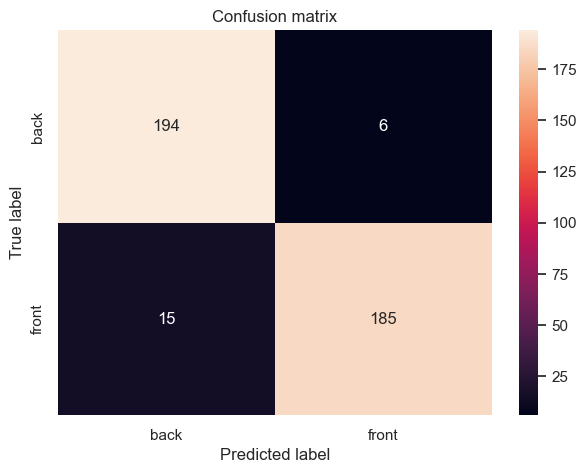

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# confusion matrix
ic_cm_old = confusion_matrix(ic_validations_labels, ic_predictions > 0.5)

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_xticklabels(val_ds.class_names)
ax.set_yticklabels(val_ds.class_names)
ax.set_title("Confusion matrix")

plt.show()

The *Precision* of this model is about $95.93$% and the *Recall* is $97.5$% with a *Threshold* of $0.5$%. There are $23$ wrong predictions of a **correct** picture and $566$ good predictions.

In [12]:
# get more granularity in the predictions
ic_preds_1 = ic_predictions > 0.5
ic_prediction_1 = ic_predictions[ic_preds_1]  # get the probs predictions from model
ic_pred_label = np.where(ic_prediction_1 > 0.5, 1, 0)  # get the labels from probs
ic_true_1 = ic_validations_labels[ic_preds_1]  # get the true values for predictions
ic_errors_1 = np.where(ic_pred_label != ic_true_1, True, False) # get the errors
ic_errors_1_images = np.array(val_ds.file_paths)[ic_preds_1][ic_errors_1]  # get the images that are errors

(6, 1)
(185, 1)


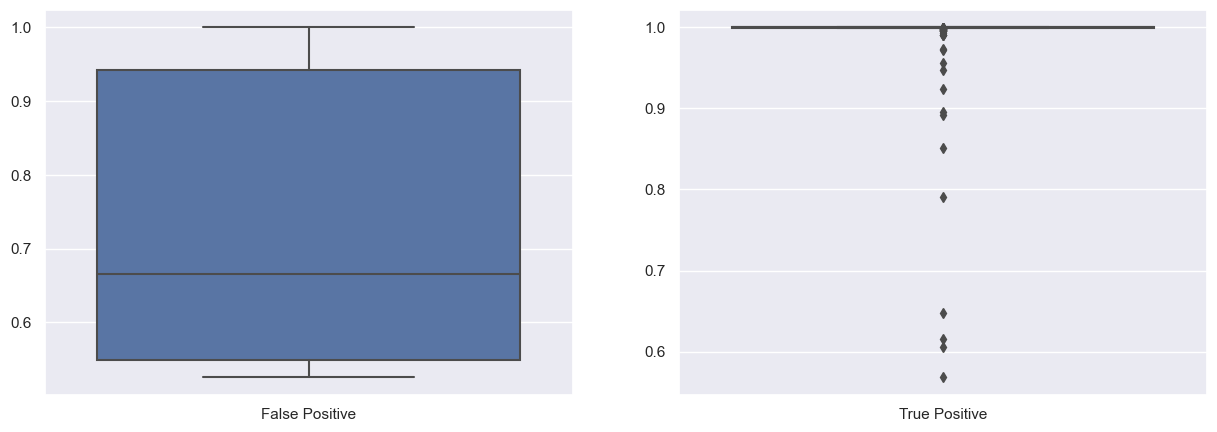

In [13]:
error_df = pd.DataFrame(ic_prediction_1[ic_errors_1], columns=['False Positive'])
correct_df = pd.DataFrame(ic_prediction_1[~ic_errors_1], columns=['True Positive'])
print(error_df.shape)
print(correct_df.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

The distribution of the predictions in case of *False Positive* is more simetrical regarding to *True Positive*'s distribution, which has a skew to $1$. Let's check those images where the algorithm predicted a **correct** picture but it was an **incorrect** one. The predicted value is the probability of a **correct** picture.

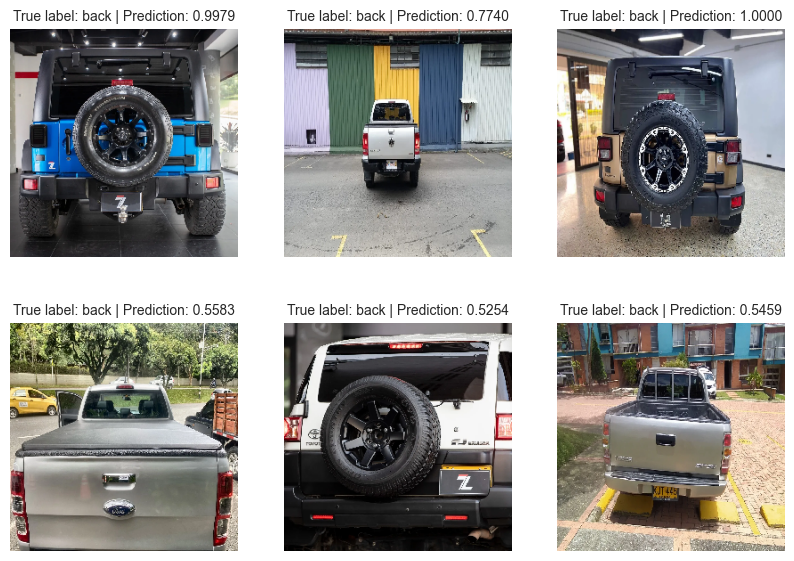

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

for i, ax in enumerate(fig.axes):
  try:
    error_image = tf.keras.preprocessing.image.load_img(ic_errors_1_images[i])
    ax.imshow(error_image)
    ax.axis('off')
    ax.set_title(f'True label: {val_ds.class_names[ic_true_1[ic_errors_1][i]]} | Prediction: {ic_prediction_1[ic_errors_1][i]:.4f}', fontsize=10)
  except IndexError:
    continue
plt.show()

### Evaluate the model on Test Set:

In [18]:
ic_model.evaluate(test_ds)

19/19 [==============================] - 2s 80ms/step - loss: 0.1246 - accuracy: 0.9650


[0.12459027767181396, 0.9650000333786011]

Overall, the model has an **accuracy** of $94.79$% in the test set.

In [19]:
ic_test_predictions = ic_model.predict(test_ds)
ic_test_labels = np.array(list(map(lambda x: x[1], test_ds.unbatch().as_numpy_iterator())))

19/19 [==============================] - 2s 93ms/step


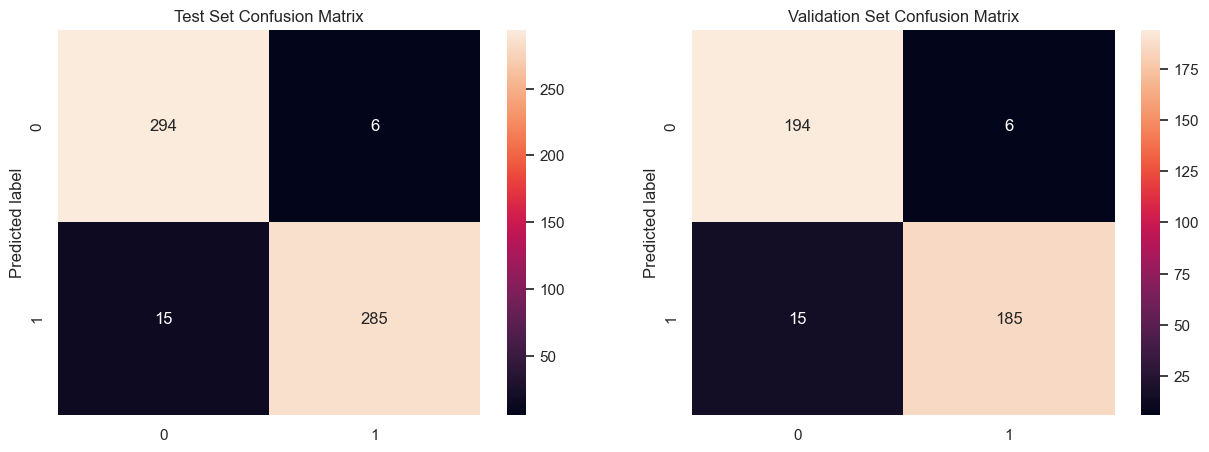

In [20]:
new_label_predictions = np.zeros(ic_test_predictions.shape)
thresholld = 0.5
for idx, row in enumerate(ic_test_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_test_cm = confusion_matrix(ic_test_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_test_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('Test Set Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

The *precision* in the test set is $93.59$%.